In [23]:
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Assuming column names have been set as follows:
# movies.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
# summaries.columns = ['wikipedia_movie_id', 'plot_summary']

# Download necessary NLTK data (run once if needed)
nltk.download('punkt')        # For tokenization
nltk.download('stopwords')    # For stopwords
nltk.download('wordnet')      # For lemmatization

# Initialize necessary NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()  # For Lemmatization
stemmer = PorterStemmer()         # For Stemming (optional)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
movies = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
characters = pd.read_csv('data//MovieSummaries/character.metadata.tsv', sep = '\t', header = None)

# Importing txt files
name_clusters = pd.read_csv('data//MovieSummaries/name.clusters.txt', sep = '\t', header = None)
summaries = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep = '\t', header = None)
tv_tropes = pd.read_csv('data//MovieSummaries/tvtropes.clusters.txt', sep = '\t', header = None)

In [25]:
movies.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
name_clusters.columns = ['name', 'freebase_movie_id']
summaries.columns = ['wikipedia_movie_id', 'plot_summary']
characters.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name', 'actor_birth', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map', 'freebase_character_id', 'freebase_actor_id']


In [26]:
def extract_dict_to_list(entry):
    # Convert the string representation of the dictionary to an actual dictionary
    entry_dict = ast.literal_eval(entry)
    # Extract the country names (values) from the dictionary
    return list(entry_dict.values())

movies['movie_countries'] = movies['movie_countries'].apply(extract_dict_to_list)
movies['movie_genres'] = movies['movie_genres'].apply(extract_dict_to_list)
movies['movie_languages'] = movies['movie_languages'].apply(extract_dict_to_list)

In [27]:
movies.head(5)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [28]:
# Function to extract the release year from the date
def extract_release_year(date_str):
    try:
        # Attempt to extract the year from the 'YYYY-MM-DD' format
        return pd.to_datetime(date_str).year
    except (ValueError, TypeError):
        try:
            # Attempt to extract the year from 'YYYY' format
            return int(date_str)
        except ValueError:
            return None  # Return None for invalid or missing dates

movies['movie_release_date'] = movies['movie_release_date'].apply(extract_release_year)

In [29]:
median_release_year = movies['movie_release_date'].median(skipna=True)
movies['movie_release_date'].fillna(median_release_year, inplace=True)

median_runtime = movies['movie_runtime'].median(skipna=True)
movies['movie_runtime'].fillna(median_runtime, inplace=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_4384\2442801939.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies['movie_release_date'].fillna(median_release_year, inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_4384\2442801939.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [34]:
common_index = movies['wikipedia_movie_id'].isin(summaries['wikipedia_movie_id']) & movies['wikipedia_movie_id'].isin(characters['wikipedia_movie_id'])
filtered_movies = movies[common_index]

In [35]:
tv_tropes.columns = ['trope', 'details']
tv_tropes['details'] = tv_tropes['details'].apply(eval)
tv_tropes = tv_tropes.join(pd.json_normalize(tv_tropes['details'])).drop(columns=['details'])

In [36]:
tv_tropes.sample(2)

,trope,char,movie,id,actor
179,dirty_cop,Police Captain Hank Quinlan,Touch of Evil,/m/0k78gf,Orson Welles
144,crazy_jealous_guy,Bud White,L.A. Confidential,/m/0j_n0t,Russell Crowe


In [37]:
tv_tropes.columns = [
    'trope',
    'character_name',          # Change `char` to `character_name`
    'movie_name',              # Change `movie` to `movie_name`
    'freebase_movie_id',       # Change `id` to `freebase_movie_id`
    'actor_name'               # Change `actor` to `actor_name`
]

In [40]:
merged_characters = characters.merge(tv_tropes[['character_name', 'trope', 'actor_name']], on=['character_name', 'actor_name'],  how='left')

In [42]:
merged_characters.sample(10)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,trope
171451,19985850,/m/04yg7yp,2009-05-21,Murugan,1977-08-29,M,1.85,/m/0dryh9k,Vishal Krishna,31.0,/m/052gyh4,/m/0hh9507,/m/0gc934,NaN
292548,1219214,/m/04jdgq,2000-12-22,Simon Sheppard,1972-11-15,M,1.80,/m/02w7gg,Jonny Lee Miller,28.0,/m/02vc_4z,/m/05nb0vn,/m/01j5x6,NaN
125326,19063107,/m/04jbc7h,1967-01-25,NaN,1903-11-07,M,1.88,NaN,Dean Jagger,63.0,/m/0jztg3p,NaN,/m/03bpgs,NaN
400236,11469460,/m/02rdyyz,1996-08-12,NaN,1952,M,NaN,NaN,Gérard Meylan,44.0,/m/0bgbtrd,NaN,/m/04mk98z,NaN
51560,31302696,/m/0bnnrxx,1990,NaN,NaN,NaN,NaN,NaN,Cécile Reigher,NaN,/m/0bnnrz2,NaN,/m/0bfdmxh,NaN
8223,8231713,/m/026x0dg,2001,NaN,1985-09-03,M,1.62,NaN,Carlo Aquino,15.0,/m/0dh6cys,NaN,/m/03gwtfc,NaN
194070,1346908,/m/04vl3c,2000-07-07,George,NaN,M,NaN,NaN,Brian McLaughlin,NaN,/m/0c1q41q,/m/0g8n76x,/m/0c1q41t,NaN
134298,28359749,/m/0crg080,1952-03-10,NaN,1926-11-24,M,NaN,NaN,Toralv Maurstad,25.0,/m/0ggll3z,NaN,/m/027kb3z,NaN
183853,28492996,/m/0crjhrf,2003,NaN,1974-04-17,M,NaN,NaN,Krešimir Mikić,28.0,/m/0gdrzmw,NaN,/m/0cm1ds6,NaN
350970,5442467,/m/0dm27f,1999,NaN,NaN,M,NaN,NaN,Kim Robert Koscki,NaN,/m/0jt82p,NaN,/m/0jt7zh,NaN


In [ ]:
characters_with_tropes = merged_characters[~merged_characters['trope'].isnull()]

In [54]:
characters_with_tropes = characters_with_tropes.merge(movies[['wikipedia_movie_id', 'movie_name']], on='wikipedia_movie_id', how='left')


In [56]:
characters_with_tropes = characters_with_tropes.merge(movies[['wikipedia_movie_id', 'movie_box_office_revenue']], on='wikipedia_movie_id', how='left')

In [59]:
characters_with_tropes = characters_with_tropes[~characters_with_tropes['movie_box_office_revenue'].isnull()]

In [60]:
characters_with_tropes

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,trope,movie_name,movie_box_office_revenue
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,Straw Dogs,11148828.0
4,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person,Death to Smoochy,8382938.0
5,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker,Serenity,38869464.0
8,445066,/m/0299hs,1987-07-17,Dick Jones,1938-07-23,M,1.88,NaN,Ronny Cox,48.0,/m/0k2m8v,/m/0h5q83s,/m/032qgs,corrupt_corporate_executive,RoboCop,53424681.0
9,445066,/m/0299hs,1987-07-17,RoboCop,1947-06-24,M,1.83,NaN,Peter Weller,40.0,/m/0h5q82q,/m/0h3w0g,/m/04t969,fastest_gun_in_the_west,RoboCop,53424681.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,52549,/m/0dtfn,1977-05-25,Darth Vader,1931-01-17,M,1.87,/m/0x67,James Earl Jones,46.0,/m/02nv74t,/m/0f2y0,/m/0f6_x,master_swordsman,Star Wars Episode IV: A New Hope,775398007.0
716,31422455,/m/0dkc35r,2011-11-04,Kumar Patel,1977-04-23,M,1.78,/m/0g0x7_,Kal Penn,34.0,/m/0dkc35n,/m/03h0df_,/m/03l3ln,slacker,A Very Harold & Kumar 3D Christmas,35387212.0
717,31422455,/m/0dkc35r,2011-11-04,Kumar Patel,1977-04-23,M,1.78,/m/0g0x7_,Kal Penn,34.0,/m/0dkc35n,/m/03h0df_,/m/03l3ln,slacker,A Very Harold & Kumar 3D Christmas,35387212.0
718,31422455,/m/0dkc35r,2011-11-04,Kumar Patel,1977-04-23,M,1.78,/m/0g0x7_,Kal Penn,34.0,/m/0dkc35n,/m/03h0df_,/m/03l3ln,stoner,A Very Harold & Kumar 3D Christmas,35387212.0


In [68]:
characters_with_tropes = characters_with_tropes.drop_duplicates()

In [107]:
def get_year(date):
        if isinstance(date, (int, float)):  # If it's already a year
            return int(date)
        elif isinstance(date, str):  # If it's a string, try to parse it as a date
            try:
                return pd.to_datetime(date).year
            except ValueError:
                return None  # Return None if date can't be parsed
        elif hasattr(date, 'year'):  # If it's a datetime object
            return date.year
        return None

characters_with_tropes['years_only'] = characters_with_tropes.apply(
        lambda row: get_year(row['movie_release_date']),
        axis=1
    )

Now let's adjust box office revenue to inflation 

In [123]:
import cpi

characters_with_tropes['adjusted_revenue'] = characters_with_tropes.apply(
        lambda row: cpi.inflate(row['movie_box_office_revenue'], row['years_only'], to=2015),
        axis=1
    )

In [126]:
trope_counts_ = characters_with_tropes['trope'].value_counts().reset_index()
trope_counts_.columns = ['trope', 'count']
trope_counts_ = trope_counts_[trope_counts_['count'] > 8]
print(trope_counts_) 

                          trope  count
0                  byronic_hero     24
1                        stoner     23
2              master_swordsman     22
3   corrupt_corporate_executive     22
4             crazy_jealous_guy     22
5                    final_girl     18
6               psycho_for_hire     16
7                loveable_rogue     14
8             father_to_his_men     14
9              eccentric_mentor     14
10                      charmer     13
11          hitman_with_a_heart     12
12                  dumb_blonde     12
13             brainless_beauty     12
14          arrogant_kungfu_guy     12
15                  surfer_dude     11
16                    jerk_jock     11
17                      slacker     11
18              cultured_badass     10
19           heartbroken_badass     10
20                tranquil_fury     10
21             gadgeteer_genius     10
22                bounty_hunter      9
23                         ditz      9
24                    tri

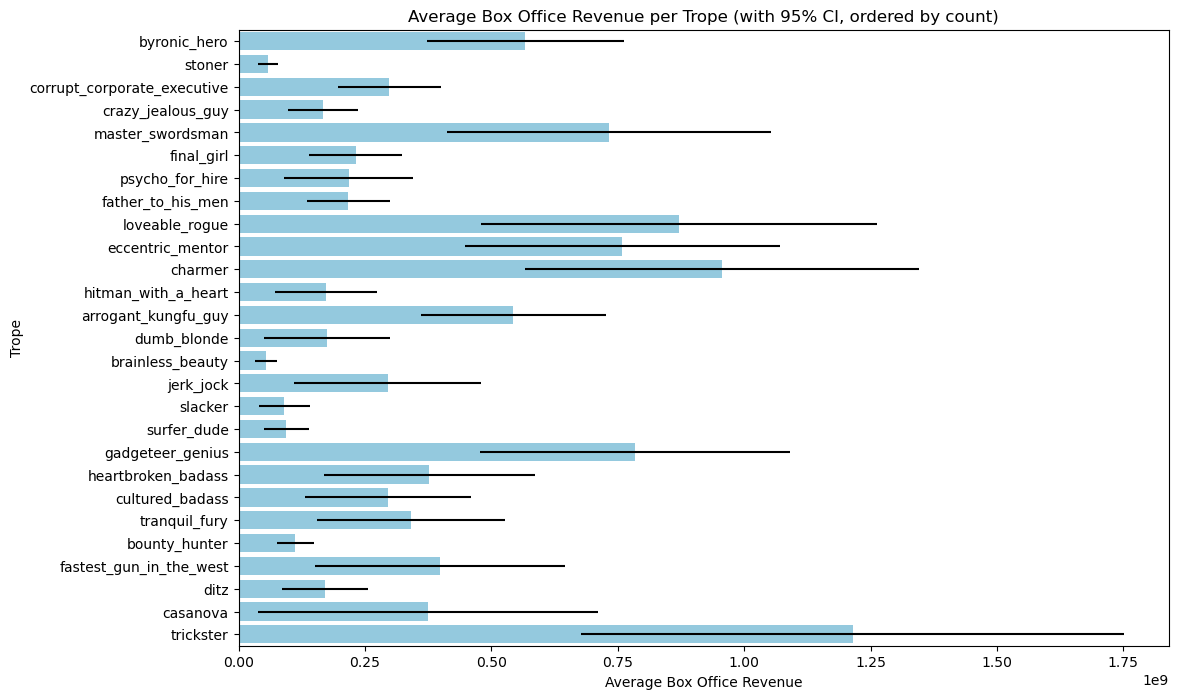

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_avg_revenue_per_trope(df):
    # Filter tropes with at least 8 occurrences
    trope_counts = df['trope'].value_counts()
    tropes_with_min_count = trope_counts[trope_counts > 8].index
    filtered_df = df[df['trope'].isin(tropes_with_min_count)]

    # Group by trope, calculate mean and confidence intervals
    trope_stats = filtered_df.groupby('trope')['adjusted_revenue'].agg(['mean', 'count', 'std'])
    trope_stats['ci95_hi'] = trope_stats['mean'] + 1.96 * trope_stats['std'] / trope_stats['count']**0.5
    trope_stats['ci95_lo'] = trope_stats['mean'] - 1.96 * trope_stats['std'] / trope_stats['count']**0.5
    trope_stats = trope_stats.reset_index()

    # Sort by count in descending order
    trope_stats = trope_stats.sort_values(by='count', ascending=False)

    # Plot with confidence intervals
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='mean', y='trope', data=trope_stats,
        xerr=(trope_stats['ci95_hi'] - trope_stats['ci95_lo']) / 2, color='skyblue',
        order=trope_stats['trope']
    )
    plt.xlabel('Average Box Office Revenue')
    plt.ylabel('Trope')
    plt.title('Average Box Office Revenue per Trope (with 95% CI, ordered by count)')
    plt.show()

# Call the function with your DataFrame
plot_avg_revenue_per_trope(characters_with_tropes)


Première vue très bancale par rapport aux films ou tropes et box office revenue dispo. Pas grand chose à conclure vu que d'autres facteurs surement plus importants (ex pour les films avec trickster trope: c que des johnny depp, brad pitt ou harrison ford dcp evidemment que le revenue est élevé, aussi très peu de données)